# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

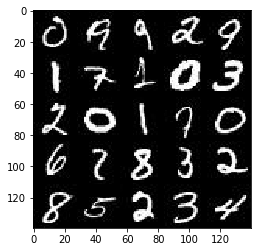

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

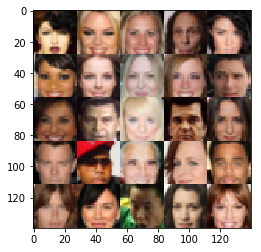

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32, 
                                shape=(None, image_width, image_height, image_channels), 
                                name='input_real') 
    input_z = tf.placeholder(dtype=tf.float32, 
                             shape=(None, z_dim), 
                             name='input_z')
    lr = tf.placeholder(dtype=tf.float32, 
                        name='learning_rate')

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        init = tf.contrib.layers.xavier_initializer
        
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(inputs=images, 
                                 filters=16, 
                                 kernel_size=9, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=init())
        relu1 = tf.maximum(conv1*alpha, conv1)
        # 14x14x16
        
        conv2 = tf.layers.conv2d(inputs=relu1, 
                                 filters=64, 
                                 kernel_size=9, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=init())
        norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(norm2*alpha, norm2)
        # 7x7x64

        conv3 = tf.layers.conv2d(inputs=relu2, 
                                 filters=256, 
                                 kernel_size=9, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=init())
        norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(norm3*alpha, norm3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        # dropout
        output = tf.nn.dropout(output, 1.0)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        fc = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        fc = tf.reshape(fc, (-1, 7, 7, 256))
        fc = tf.layers.batch_normalization(fc, training=is_train)
        fc = tf.maximum(fc*alpha, fc)
        # 7x7x256
        
        h1 = tf.layers.conv2d_transpose(inputs=fc, 
                                        filters=128, 
                                        kernel_size=9, 
                                        strides=1, 
                                        padding='same')
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(h1*alpha, h1)
        h1 = tf.nn.dropout(h1, 1.0)
        # 7x7x128
        
        h2 = tf.layers.conv2d_transpose(inputs=h1, 
                                        filters=64, 
                                        kernel_size=9, 
                                        strides=2, 
                                        padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(h2*alpha, h2)
        h2 = tf.nn.dropout(h2, 1.0)
        # 14x14x64
        
        h3 = tf.layers.conv2d_transpose(inputs=h2, 
                                        filters=16, 
                                        kernel_size=9, 
                                        strides=2, 
                                        padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(h3*alpha, h3)
        h3 = tf.nn.dropout(h3, 1.0)
        # 28x28x16

        # Output layer
        logits = tf.layers.conv2d_transpose(inputs=h3, 
                                            filters=out_channel_dim, 
                                            kernel_size=9, 
                                            strides=1, 
                                            padding='same')
        logits = tf.nn.dropout(logits, 1.0)
        # 28x28x3
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # One Sided Label Smoothing for Discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*np.random.uniform(0.8, 1.0)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)*np.random.uniform(0.0, 0.2)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    (input_real, input_z, lr) = model_inputs(image_width, 
                                             image_height, 
                                             image_channels, 
                                             z_dim)
    
    (d_loss, g_loss) = model_loss(input_real, 
                                  input_z, 
                                  image_channels)
    
    (d_train_opt, g_train_opt) = model_opt(d_loss, 
                                           g_loss, 
                                           lr, 
                                           beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # normalize input
                batch_images *= 2.0
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                feed_dict = {input_real : batch_images, 
                             input_z : batch_z,
                             lr : learning_rate}
                
                _ = sess.run(d_train_opt, feed_dict=feed_dict)
                _ = sess.run(g_train_opt, feed_dict=feed_dict)
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_d_loss = d_loss.eval(feed_dict)
                    train_g_loss = g_loss.eval(feed_dict)
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                
                if steps % 100 == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 3.0027
Epoch 1/2... Discriminator Loss: 2.0279... Generator Loss: 5.3834
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 4.9704
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 1.5217
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 2.1745
Epoch 1/2... Discriminator Loss: 2.0379... Generator Loss: 0.1261
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 2.0219
Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 0.7997
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.3530
Epoch 1/2... Discriminator Loss: 0.7209... Generator Loss: 1.9992


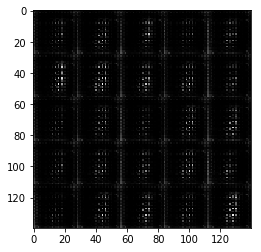

Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 1.2081
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 1.6347... Generator Loss: 0.2260
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 1.5270
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.3247
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.5036
Epoch 1/2... Discriminator Loss: 1.1766... Generator Loss: 0.8031
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.2875


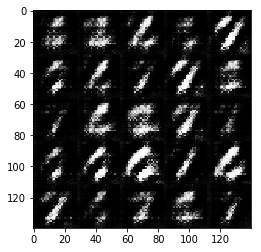

Epoch 1/2... Discriminator Loss: 1.9201... Generator Loss: 0.1740
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.8348
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.5277
Epoch 1/2... Discriminator Loss: 1.7218... Generator Loss: 0.2457
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.5004
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.9421
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.5032


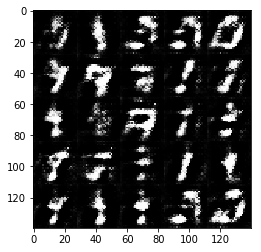

Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.4873
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.5111... Generator Loss: 0.5040
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.4162
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 1.0377


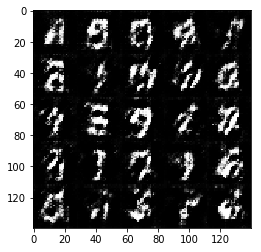

Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.8952
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.4521
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.4426... Generator Loss: 0.3310
Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 0.3238
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.8392
Epoch 1/2... Discriminator Loss: 1.4992... Generator Loss: 0.3378
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.7499


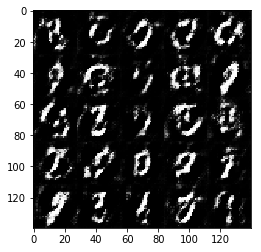

Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.6215
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.4873
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.3652
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.4468


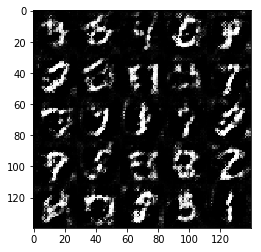

Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.5662
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.2867
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.5043
Epoch 1/2... Discriminator Loss: 1.2965... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.9028
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.5999
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.5054
Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.4874


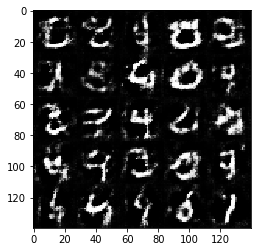

Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.5058
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.2797... Generator Loss: 0.6744
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.5082
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.5678
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.5083


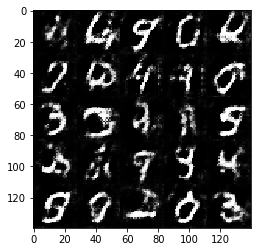

Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.4043
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.5271
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.4470
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.5305
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.4907
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.3637


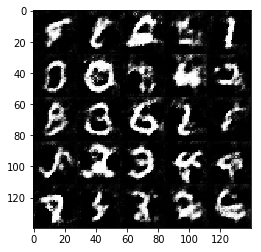

Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.5008
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.4959
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.5313
Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.5317
Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 0.6730


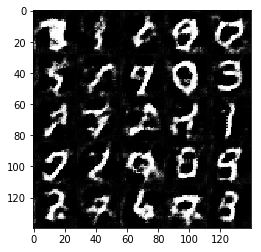

Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.6727
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 0.6106


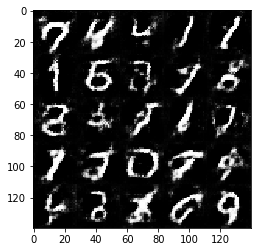

Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.5519
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.5452
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.4990
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.4445
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.4110
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.3748


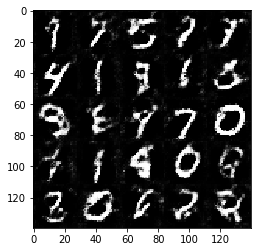

Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.5284
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.3510... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.5571
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.3589
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.7359


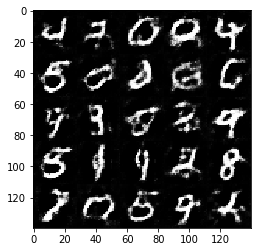

Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.6313
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.4749
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.5531
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.6143
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 0.4441
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.3859
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.6042


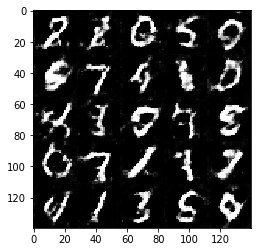

Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.5908
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.3221
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.5172
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.3389
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.4105
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 0.6086


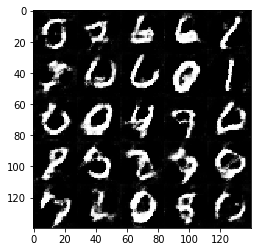

Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.4711
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.2884... Generator Loss: 0.5308
Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.4097
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.6770
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.7337


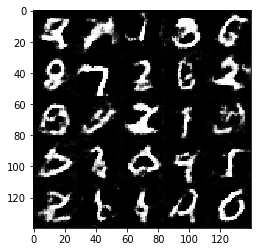

Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.2939
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.6867
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.6128


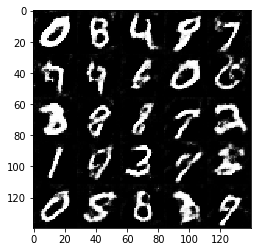

Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.6190
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.5343
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.5516
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.5656


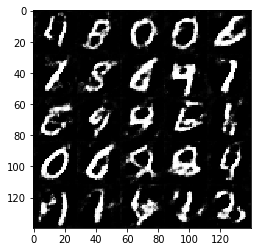

Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.6518
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.4021
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.8095
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.5312


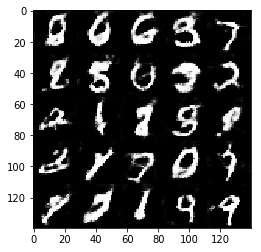

Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 1.2643... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.6661
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.4330
Epoch 2/2... Discriminator Loss: 1.2692... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.5920
Epoch 2/2... Discriminator Loss: 1.1851... Generator Loss: 0.5810
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.5335
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 0.5133
Epoch 2/2... Discriminator Loss: 1.4568... Generator Loss: 0.2878


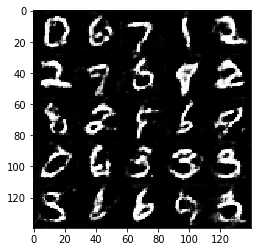

Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.5004
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 0.5148
Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 0.5376
Epoch 2/2... Discriminator Loss: 1.6397... Generator Loss: 0.2281
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.5818
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.6817


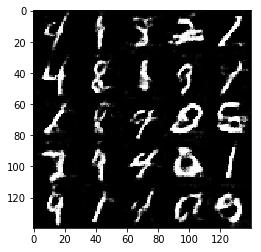

Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.5985
Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 0.3041
Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.4605


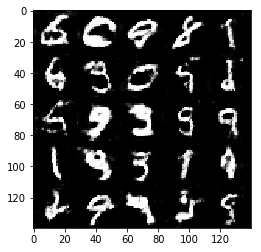

Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.5980
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.5034
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.4446
Epoch 2/2... Discriminator Loss: 1.4668... Generator Loss: 0.3269
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 0.5540
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.8262


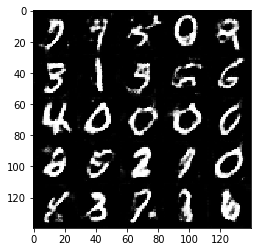

Epoch 2/2... Discriminator Loss: 1.1930... Generator Loss: 0.4785
Epoch 2/2... Discriminator Loss: 1.5270... Generator Loss: 0.2716
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 0.5066
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 0.6445
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.4161
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.3476
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.4048
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 0.5413


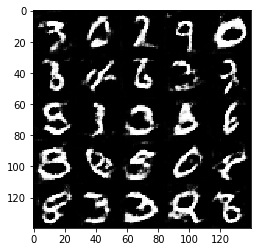

Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.4571
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.5291... Generator Loss: 0.2529
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.4558
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.4481


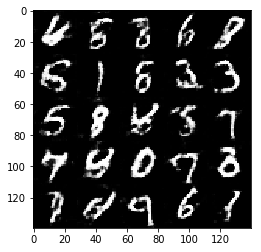

Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.3613
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.6055
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.6999
Epoch 2/2... Discriminator Loss: 1.5952... Generator Loss: 0.2380
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.6634
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 0.9081
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.5860
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.5563


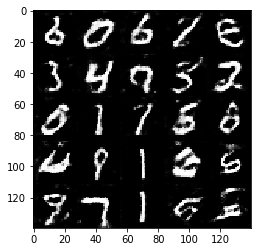

Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.4333
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.5458
Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.4387
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.5802
Epoch 2/2... Discriminator Loss: 1.3768... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 0.4683
Epoch 2/2... Discriminator Loss: 1.3261... Generator Loss: 0.4413


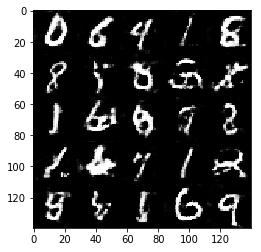

Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.5427
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.3421
Epoch 2/2... Discriminator Loss: 1.2397... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.4816
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.5399
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 0.5688


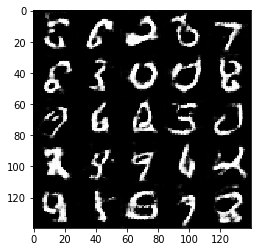

Epoch 2/2... Discriminator Loss: 1.2829... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 1.4969... Generator Loss: 0.3021
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.3699
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.2559


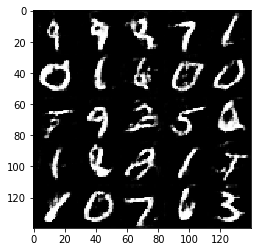

Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.4305
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.5932
Epoch 2/2... Discriminator Loss: 1.5537... Generator Loss: 0.2603
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.5704
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.5221... Generator Loss: 0.2604
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.2994
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.5411


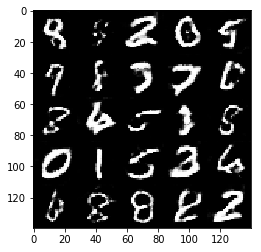

Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.4586
Epoch 2/2... Discriminator Loss: 1.2220... Generator Loss: 0.4640
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 1.1924... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 0.7953
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.6718... Generator Loss: 0.2224
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 1.5834... Generator Loss: 0.2408
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.4847


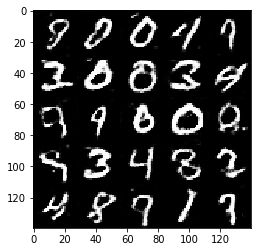

Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 1.1595... Generator Loss: 0.5229
Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.3366
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 1.5002... Generator Loss: 0.2860
Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.3685
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 0.4904


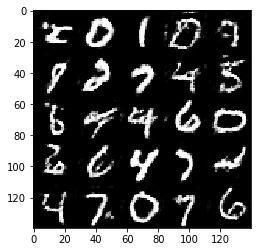

Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.5001
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.3254
Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 0.3603
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.4680... Generator Loss: 0.2845
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.4229
Epoch 2/2... Discriminator Loss: 1.1772... Generator Loss: 0.5405


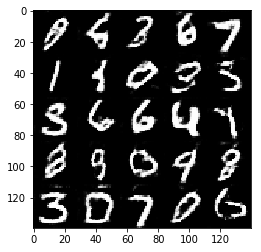

Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 0.7867
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.8440
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.4763
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 1.5244... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 1.1599
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.8082


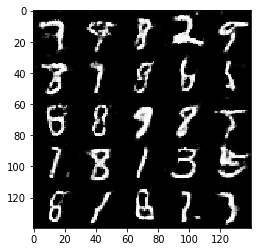

Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 1.4365... Generator Loss: 0.3040
Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 0.4489
Epoch 2/2... Discriminator Loss: 1.2144... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.0995... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.2108... Generator Loss: 0.5017
Epoch 2/2... Discriminator Loss: 1.1919... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.3882


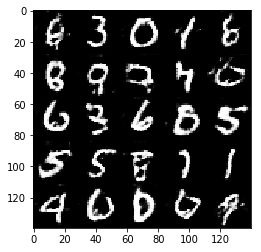

Epoch 2/2... Discriminator Loss: 1.3476... Generator Loss: 0.3644
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.3997
Epoch 2/2... Discriminator Loss: 1.4557... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.5078
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.3564
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.3641
Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.3030
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.4457


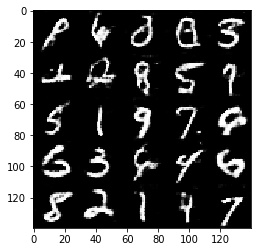

Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.5141
Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.3760
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 0.6216
Epoch 2/2... Discriminator Loss: 1.1863... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.5251


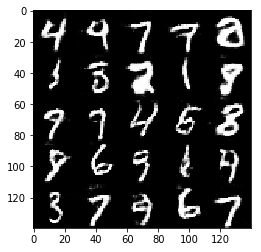

Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.4224
Epoch 2/2... Discriminator Loss: 1.7138... Generator Loss: 0.1907
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.4656


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2194... Generator Loss: 13.8116
Epoch 1/1... Discriminator Loss: 2.2659... Generator Loss: 13.0594
Epoch 1/1... Discriminator Loss: 1.9453... Generator Loss: 11.1393
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 7.0878
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 3.2637
Epoch 1/1... Discriminator Loss: 2.2845... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.0185


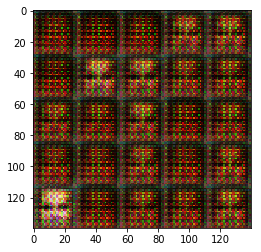

Epoch 1/1... Discriminator Loss: 1.6756... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.9526
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.9852


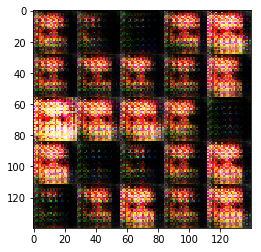

Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 1.6691... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.4290


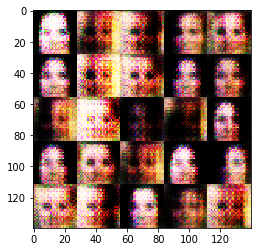

Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.9292


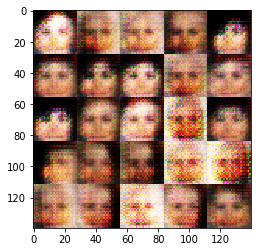

Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.8136... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.9460


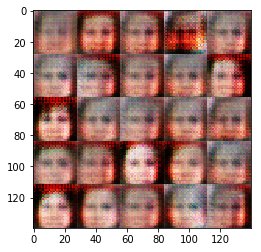

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.7077... Generator Loss: 0.4596
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7951


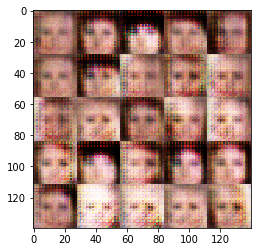

Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7335


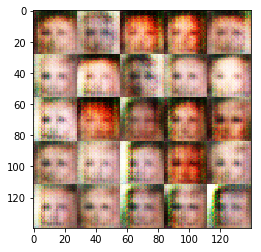

Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7371


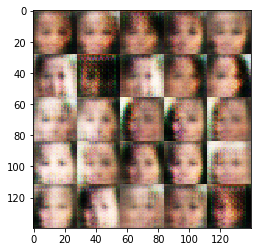

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6278


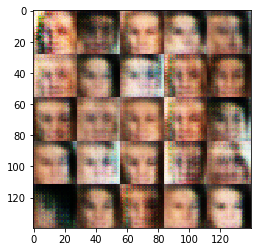

Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8207


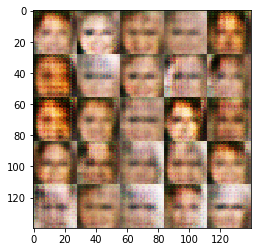

Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.8598


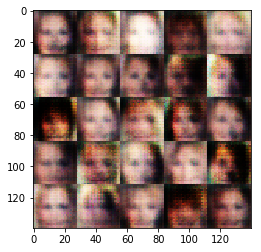

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7451


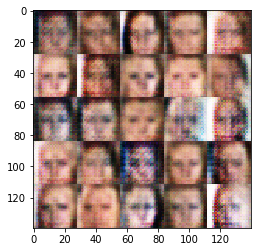

Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7614


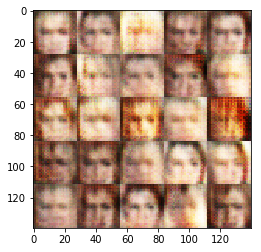

Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7175


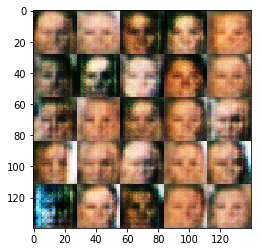

Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8337


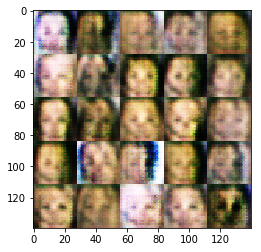

Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7562


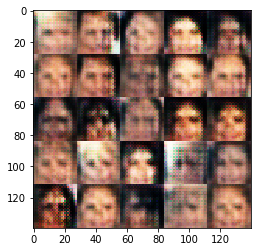

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.6325... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5864


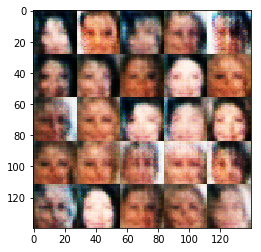

Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7420


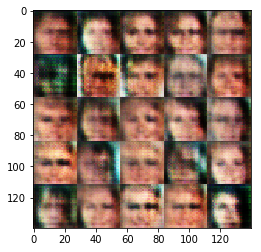

Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7677


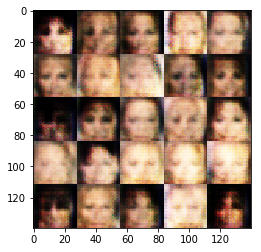

Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7917


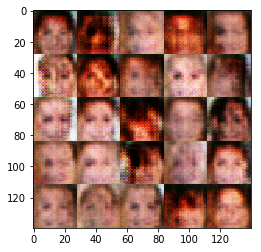

Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.7475... Generator Loss: 2.0265


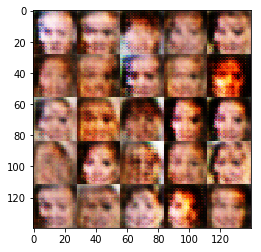

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.5342


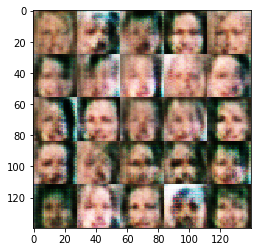

Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7531


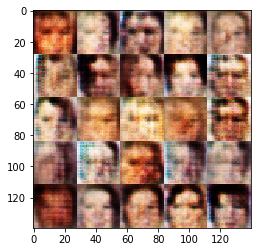

Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6540


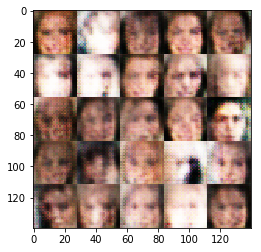

Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 1.0400


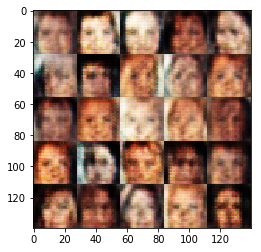

Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.5985


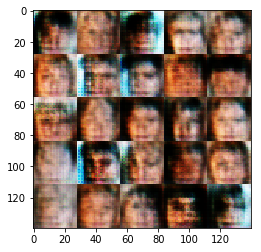

Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8506


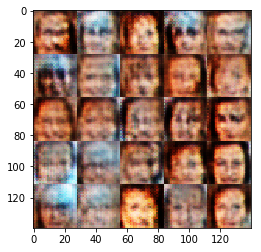

Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7753


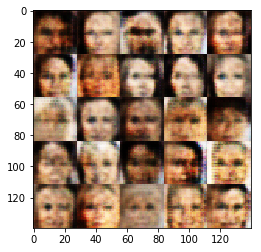

Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8662


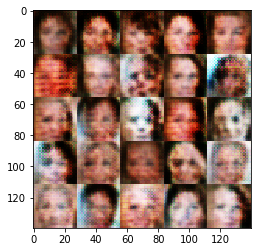

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8084


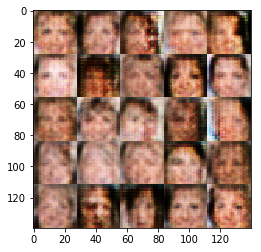

Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.8900


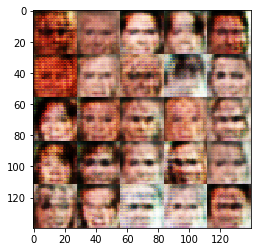

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8544


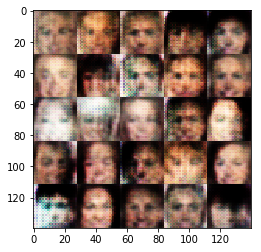

Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 1.4531
Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9497


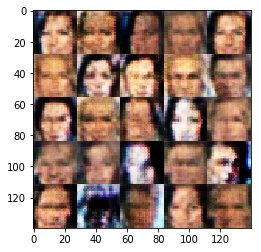

Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.9167


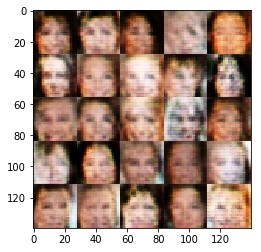

Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.6858


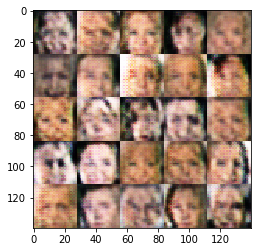

Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.0719
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7384


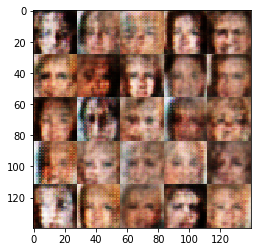

Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7131


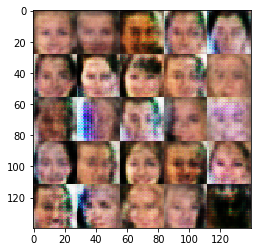

Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.4768


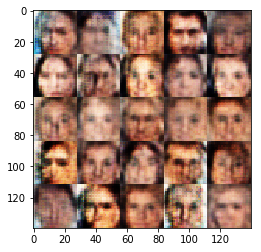

Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.9722


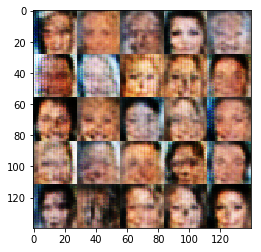

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6992


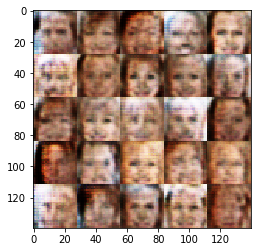

Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.6555


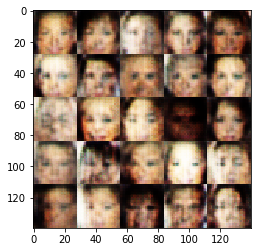

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.6682


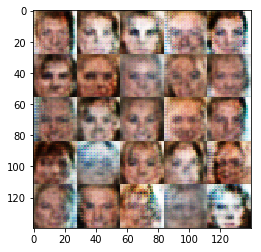

Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6517


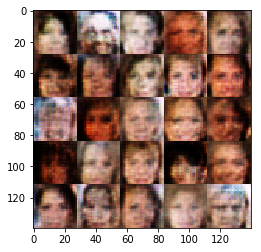

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.8211


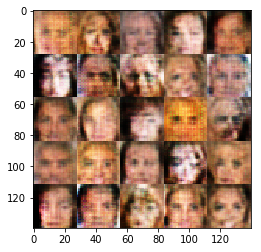

Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6589


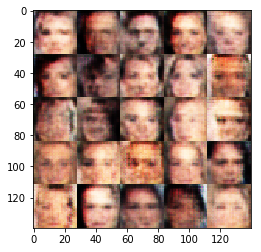

Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6109


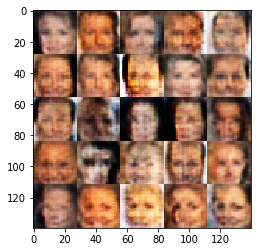

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7190


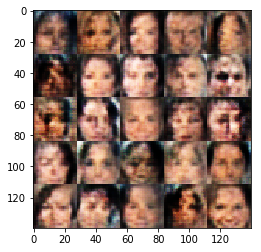

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8026


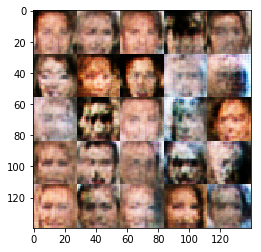

Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6494


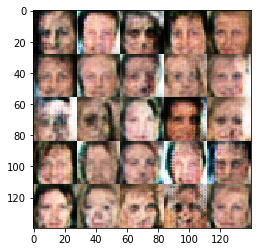

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8983


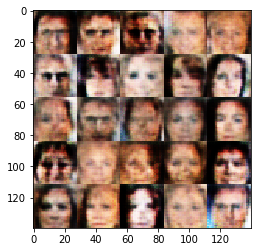

Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6866


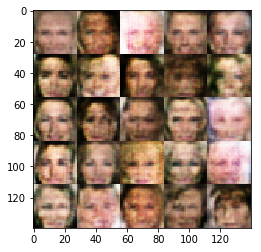

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5714


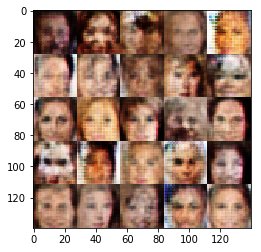

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.8538


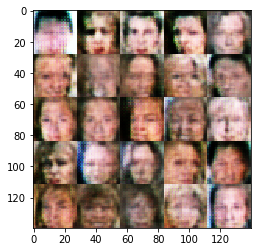

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7066


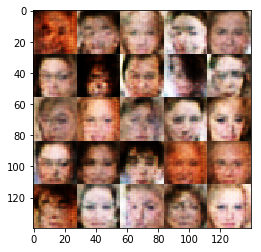

Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7275


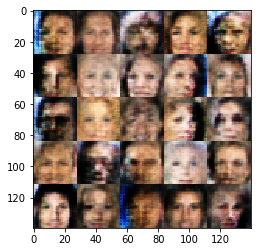

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4926


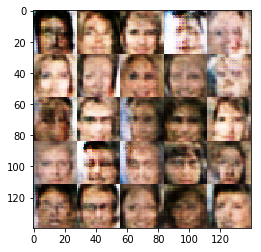

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7106


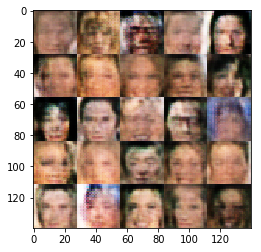

Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7143


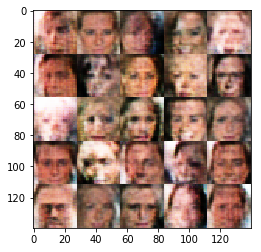

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7748


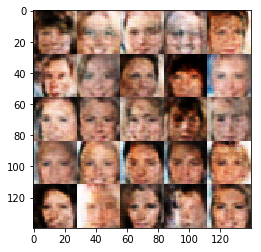

Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 1.0710


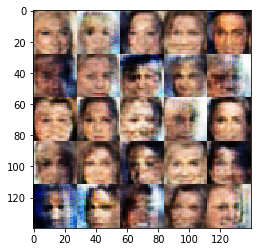

Epoch 1/1... Discriminator Loss: 1.5823... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.5289


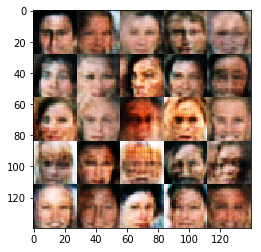

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.5904


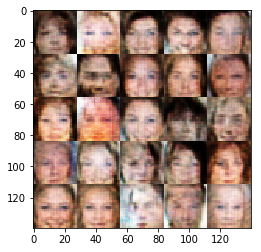

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.7616


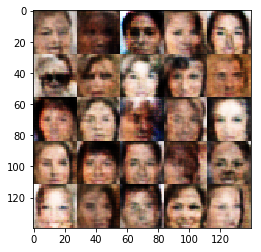

Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.8043


In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.